# Local registration with ICP

    In the RGBD folder we have the first 400 images from one of the datasets from: (http://redwood-data.org/indoor_lidar_rgbd/download.html)


    If you want to display directly in jupyter notebook replace the **draw_registrations** with this:

```python
from open3d import JVisualizer

def draw_registrations(source, target, transformation = None, recolor = False):
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        if(recolor):
            source_temp.paint_uniform_color([1, 0.706, 0])
            target_temp.paint_uniform_color([0, 0.651, 0.929])
        if(transformation is not None):
            source_temp.transform(transformation)
        visualizer = JVisualizer()
        visualizer.add_geometry(source_temp)
        visualizer.add_geometry(target_temp)
        visualizer.show()
```

In [17]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import copy
        
# Helper function to draw registrations (reccomended)
def draw_registrations(source, target, transformation = None, recolor = False):
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        if(recolor):
            source_temp.paint_uniform_color([1, 0.706, 0])
            target_temp.paint_uniform_color([0, 0.651, 0.929])
        if(transformation is not None):
            source_temp.transform(transformation)
        o3d.visualization.draw_geometries([source_temp, target_temp])

## Creating pointclouds from image data
Now we are going to try to create our own pointclouds from rgb and depth images.

In [18]:
# Read in images. We have images 000000 - 0000400
color_raw0 = o3d.io.read_image("RGBD/color/000100.jpg")
depth_raw0 = o3d.io.read_image("RGBD/depth/000100.png")

color_raw1 = o3d.io.read_image("RGBD/color/000105.jpg")
depth_raw1 = o3d.io.read_image("RGBD/depth/000105.png")

Create pointclouds from rgb + depth images.

If you set *convert_rgb_to_intensity = False* you will retain the colors from the rgb image.

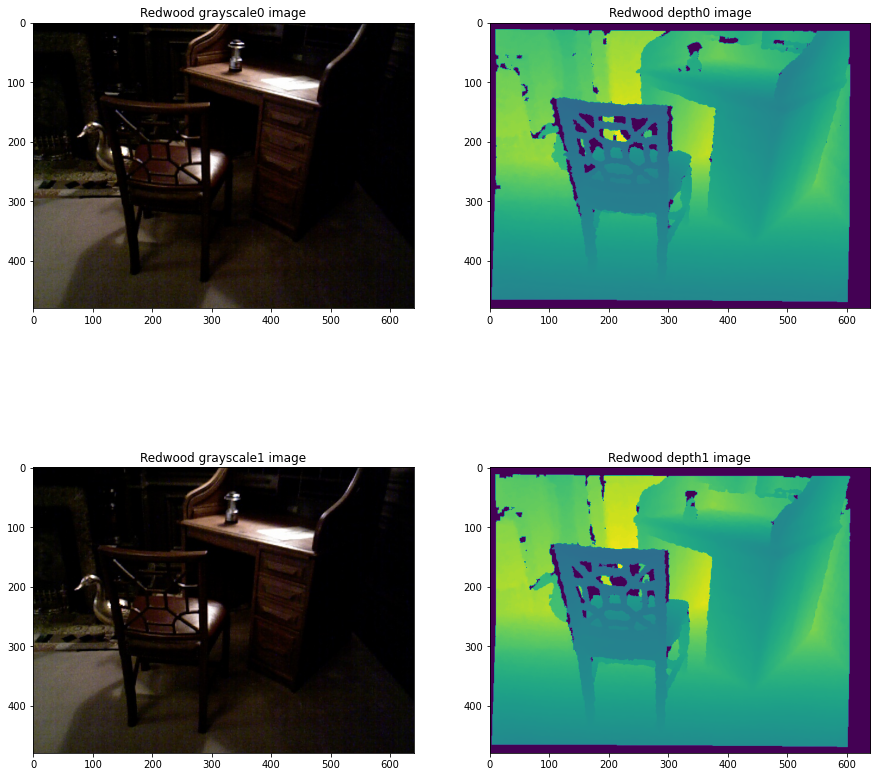

In [19]:
rgbd_image0 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw0, 
    depth_raw0, 
    convert_rgb_to_intensity = False)

rgbd_image1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw1, 
    depth_raw1, 
    convert_rgb_to_intensity = False)

#show images
fig= plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('Redwood grayscale0 image')
plt.imshow(rgbd_image0.color)

plt.subplot(222)
plt.title('Redwood depth0 image')
plt.imshow(rgbd_image0.depth)

plt.subplot(223)
plt.title('Redwood grayscale1 image')
plt.imshow(rgbd_image1.color)

plt.subplot(224)
plt.title('Redwood depth1 image')
plt.imshow(rgbd_image1.depth)

plt.show()


## Images to Pointcloud
Now we create point clouds from the rgbd images we just created.


Here we use **PinholeCameraIntrinsicParameters.PrimeSenseDefault** as default camera parameter. 

It has image resolution 640x480, focal length (fx, fy) = (525.0, 525.0), and optical center (cx, cy) = (319.5, 239.5). 

An identity matrix is used as the default extrinsic parameter. pcd.transform applies an up-down flip transformation on the point cloud for better visualization purpose.


If it becomes too slow you can downsample the pointcloud.

In [20]:
# Source pointcloud
camera = o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

source = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image0, camera)

# Target pointcloud
target = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image1, camera)

# Flip it, otherwise the pointcloud will be upside down
source.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
target.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

# Draw
draw_registrations(source, target, recolor=True)

### Evaluation of pointclouds

Before we can run ICP we evaluate our source and target pointclouds. This gives us a measure to see if we need a better initial transformation or not.

[The function evaluate_registration calculates two main metrics. fitness measures the overlapping area (# of inlier correspondences / # of points in target). Higher the better. inlier_rmse measures the RMSE of all inlier correspondences. Lower the better.](http://www.open3d.org/docs/latest/tutorial/Basic/icp_registration.html)

In [21]:
##############
# Downsample #
##############
voxel_size = 0.05
# 1 Downsample both point clouds
source = source.voxel_down_sample(voxel_size=voxel_size)
target = target.voxel_down_sample(voxel_size=voxel_size)
# 2 Estimate surface normals of pointclouds
source.estimate_normals()
target.estimate_normals()

In [22]:
# Draw
draw_registrations(source, target, recolor=True)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Ugyldig referanse. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Forespurt transformeringsoperasjon er ikke støttet. 


In [23]:
# Parameters
threshold = 0.02
trans_init = np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

#Evaluate registration
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(source, target, threshold, trans_init)
print(evaluation)

Initial alignment
RegistrationResult with fitness=3.940713e-01, inlier_rmse=1.441965e-02, and correspondence_set size of 1449
Access transformation to get result.


## ICP

Now try to call icp with your point clouds and your initial transformation.

Initially we use:
```Python
point_to_plane =  o3d.registration.TransformationEstimationPointToPlane()

icp_result = o3d.registration.registration_icp(
    source, target, threshold, trans_init,
    point_to_plane)

```

In [24]:
###
# ICP code here
###
point_to_point =  o3d.pipelines.registration.TransformationEstimationPointToPoint(False)
point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()

icp_result = o3d.pipelines.registration.registration_icp(
    source,
    target,
    max_correspondence_distance=threshold,
    init=trans_init, 
    estimation_method=point_to_plane
    )

#draw_registrations(source, target, icp_result.transformation, True)
#draw_registrations(source, target, icp_result.transformation)

# Exersices

### A)
If you increase the amount of steps from the original image so from i.e. 000000-000001 to 00000-000300 what happens?
### B)
Can you tweak the parameters *threshold* and *trans_init* to combat some of the ill effects that starts appearing?
### C)
Again try to use 
```Python
point_to_plane =  o3d.registration.TransformationEstimationPointToPlane()

reg_p2p = o3d.registration.registration_icp(
    source, target, threshold, trans_init,
    point_to_plane)
```

This requires you to find the normals for each point cloud use:
```python
    source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                            max_nn=30),fast_normal_computation=True)
```
Compare the resulting translations of the two methods is one better than the other?
### D)
Extend this and try to see how much of the bedroom you can reconstruct from the rgb and depth images.
you can extend a pointcloud by new = source + target remember to resample the point cloud some times so it does not get too large down_source = source.voxel_down_sample(voxel_size=0.05)

In [25]:
# Read in images. We have images 000000 - 0000400
color_raw0 = o3d.io.read_image("RGBD/color/000001.jpg")
depth_raw0 = o3d.io.read_image("RGBD/depth/000001.png")

color_raw1 = o3d.io.read_image("RGBD/color/000301.jpg")
depth_raw1 = o3d.io.read_image("RGBD/depth/000301.png")

#####################
# Recombine to RGBD #
#####################
rgbd_image0 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw0, 
    depth_raw0, 
    convert_rgb_to_intensity = True)

rgbd_image1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw1, 
    depth_raw1, 
    convert_rgb_to_intensity = True)

# Create camera model
camera = o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

# Source pointcloud
source = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image0, camera)

# Target pointcloud
target = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image1, camera)

# Flip it, otherwise the pointcloud will be upside down
source.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
target.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

##############
# Downsample #
##############
voxel_size = 0.01
# 1 Downsample both point clouds
source.voxel_down_sample(voxel_size=voxel_size)
target.voxel_down_sample(voxel_size=voxel_size)
# 2 Estimate surface normals of pointclouds
source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                        max_nn=30),fast_normal_computation=True)
target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                        max_nn=30),fast_normal_computation=True)

###########
# Fitness #
###########

# Parameters
threshold = 0.02
trans_init = np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

#Evaluate registration
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(source, target, threshold, trans_init)
print(evaluation)

#######
# ICP #
#######

point_to_point =  o3d.pipelines.registration.TransformationEstimationPointToPoint(False)
point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()

icp_result = o3d.pipelines.registration.registration_icp(
    source,
    target,
    max_correspondence_distance=threshold,
    init=trans_init, 
    estimation_method=point_to_plane
    )

Initial alignment
RegistrationResult with fitness=4.750577e-02, inlier_rmse=1.200469e-02, and correspondence_set size of 12461
Access transformation to get result.


In [26]:
draw_registrations(source, target, icp_result.transformation, recolor=True)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Ugyldig referanse. 


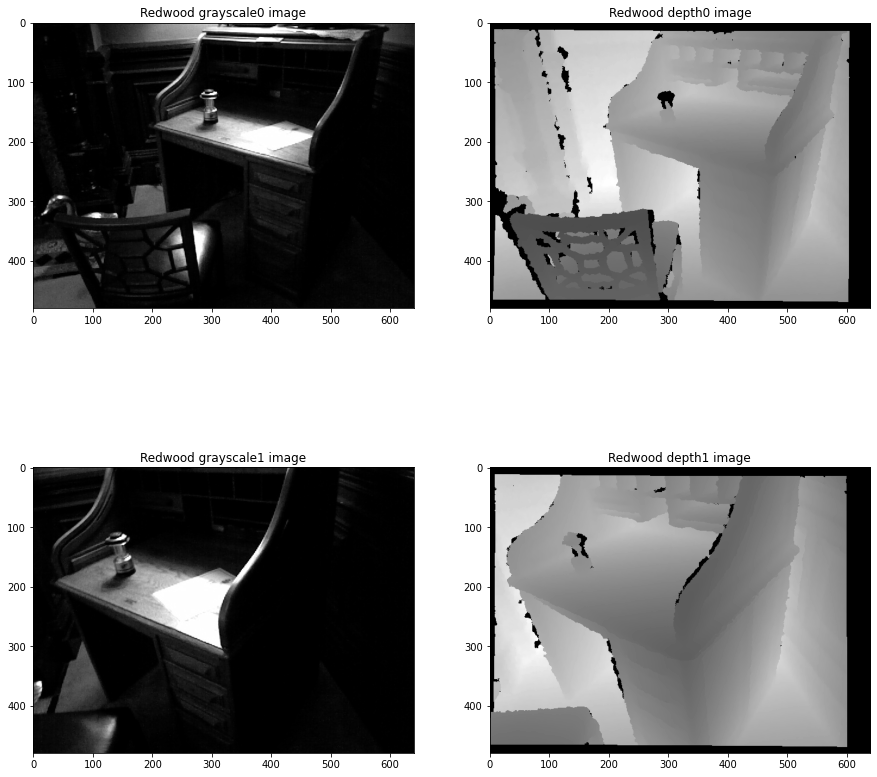

In [27]:
#### B

#show images
fig= plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('Redwood grayscale0 image')
plt.imshow(rgbd_image0.color, cmap="gray")

plt.subplot(222)
plt.title('Redwood depth0 image')
plt.imshow(rgbd_image0.depth, cmap="gray")

plt.subplot(223)
plt.title('Redwood grayscale1 image')
plt.imshow(rgbd_image1.color, cmap="gray")

plt.subplot(224)
plt.title('Redwood depth1 image')
plt.imshow(rgbd_image1.depth, cmap="gray")

plt.show()

In [28]:
###########
# Fitness #
###########

# Parameters
threshold = 1.5 # Increased so we can detect the correct points
trans_init = np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

#Evaluate registration
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(source, target, threshold, trans_init)
print(evaluation)

#######
# ICP #
#######

point_to_point =  o3d.pipelines.registration.TransformationEstimationPointToPoint(False)
point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()

icp_result = o3d.pipelines.registration.registration_icp(
    source,
    target,
    max_correspondence_distance=threshold,
    init=trans_init, 
    estimation_method=point_to_point
    )

Initial alignment
RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.523137e-01, and correspondence_set size of 262305
Access transformation to get result.


In [29]:
draw_registrations(source, target, icp_result.transformation, recolor=True)

In [30]:
# Parameters
threshold = 1.5 # Increased so we can detect the correct points
trans_init = np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()

reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    point_to_plane)

In [31]:
draw_registrations(source, target, reg_p2p.transformation, recolor=True)


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Forespurt transformeringsoperasjon er ikke støttet. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Ugyldig referanse. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Ugyldig referanse. 


In [32]:
def add_new_pc(source, no, voxel_size=0.005):
    # Read in images. We have images 000000 - 0000400
    if no<10:
        no = "00000"+str(no)
        color_raw1 = o3d.io.read_image("RGBD/color/"+no+".jpg")
        depth_raw1 = o3d.io.read_image("RGBD/color/"+no+".jpg")
    elif 10<=no<100:
        no = "0000"+str(no)
        color_raw1 = o3d.io.read_image("RGBD/color/"+no+".jpg")
        depth_raw1 = o3d.io.read_image("RGBD/color/"+no+".jpg")
    elif 100<=no<1000:
        no = "000"+str(no)
        color_raw1 = o3d.io.read_image("RGBD/color/"+no+".jpg")
        depth_raw1 = o3d.io.read_image("RGBD/color/"+no+".jpg")
    else:
        return source

    #####################
    # Recombine to RGBD #
    #####################
    rgbd_image1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color_raw1, 
        depth_raw1, 
        convert_rgb_to_intensity = True)

    # Create camera model
    camera = o3d.camera.PinholeCameraIntrinsic(
            o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

    # Target pointcloud
    target = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image1, camera)

    # Flip it, otherwise the pointcloud will be upside down
    target.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

    ##############
    # Downsample #
    ##############
    # 1 Downsample both point clouds
    #source = source.voxel_down_sample(voxel_size=voxel_size)
    #target = target.voxel_down_sample(voxel_size=voxel_size)
    # 2 Estimate surface normals of pointclouds
    source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                            max_nn=30),fast_normal_computation=True)
    target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                            max_nn=30),fast_normal_computation=True)

    #######
    # ICP #
    #######
    # Parameters
    threshold = 0.02
    trans_init = np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

    #point_to_point =  o3d.pipelines.registration.TransformationEstimationPointToPoint(False)
    point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()

    icp_result = o3d.pipelines.registration.registration_icp(
        source,
        target,
        max_correspondence_distance=threshold,
        init=trans_init, 
        estimation_method=point_to_plane
        )
    print(no, end="... ")
    # Transform the source points to targets coordinates, and add target
    new = source.transform(icp_result.transformation) + target #.voxel_down_sample(voxel_size=voxel_size)
    return new

In [33]:
def whole_process(source, voxel_size=0.005):
    
    for i in range(1, 100):
        # Read in images. We have images 000000 - 0000400
        no = 0
        if i<10:
            no = "00000"+str(i)
            color_raw1 = o3d.io.read_image("RGBD/color/"+no+".jpg")
            depth_raw1 = o3d.io.read_image("RGBD/color/"+no+".jpg")
        elif 10<=i<100:
            no = "0000"+str(i)
            color_raw1 = o3d.io.read_image("RGBD/color/"+no+".jpg")
            depth_raw1 = o3d.io.read_image("RGBD/color/"+no+".jpg")
        elif 100<=i<1000:
            no = "000"+str(i)
            color_raw1 = o3d.io.read_image("RGBD/color/"+no+".jpg")
            depth_raw1 = o3d.io.read_image("RGBD/color/"+no+".jpg")
        else:
            return source
        print(no, end="... ")

        #####################
        # Recombine to RGBD #
        #####################
        rgbd_image1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
            color_raw1, 
            depth_raw1, 
            convert_rgb_to_intensity = True)

        # Create camera model
        camera = o3d.camera.PinholeCameraIntrinsic(
                o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

        # Target pointcloud
        target = o3d.geometry.PointCloud.create_from_rgbd_image(
            rgbd_image1, camera)

        # Flip it, otherwise the pointcloud will be upside down
        target.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

        ##############
        # Downsample #
        ##############
        # 1 Downsample both point clouds
        #source = source.voxel_down_sample(voxel_size=voxel_size)
        #target = target.voxel_down_sample(voxel_size=voxel_size)
        # 2 Estimate surface normals of pointclouds
        source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                                max_nn=30),fast_normal_computation=True)
        target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                                max_nn=30),fast_normal_computation=True)

        #######
        # ICP #
        #######
        # Parameters
        threshold = 0.02
        trans_init = np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

        #point_to_point =  o3d.pipelines.registration.TransformationEstimationPointToPoint(False)
        point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()

        icp_result = o3d.pipelines.registration.registration_icp(
            source,
            target,
            max_correspondence_distance=threshold,
            init=trans_init, 
            estimation_method=point_to_plane
            )
        
        # Transform the source points to targets coordinates, and add target
        source += target.transform(icp_result.transformation) #.voxel_down_sample(voxel_size=voxel_size)
    return source
#draw_registrations(source, target, icp_result.transformation, recolor=True)
#######################
# Original pointcloud #
#######################
voxel_size = 0.05
color_raw0 = o3d.io.read_image("RGBD/color/000000.jpg")
depth_raw0 = o3d.io.read_image("RGBD/depth/000000.png")
rgbd_image0 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw0, 
    depth_raw0, 
    convert_rgb_to_intensity = True)
    
# Create camera model
camera = o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

# Source pointcloud
source = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image0, camera)

# Flip it, otherwise the pointcloud will be upside down
source.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

# 1 Downsample both point clouds
source = source.voxel_down_sample(voxel_size=voxel_size)
# 2 Estimate surface normals of pointclouds
source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                            max_nn=30),fast_normal_computation=True)

################
# Do the stuff #
################
#for i in range(1, 100):
    #source = add_new_pc(copy.deepcopy(source), i, voxel_size=voxel_size)
    #if i % 10 == 0:
    #    source=source.voxel_down_sample(voxel_size=voxel_size)

result = whole_process(copy.deepcopy(source), voxel_size=voxel_size)

000001... 000002... 000003... 000004... 000005... 000006... 000007... 000008... 000009... 000010... 000011... 000012... 000013... 000014... 000015... 000016... 000017... 000018... 000019... 000020... 000021... 000022... 000023... 000024... 000025... 000026... 

KeyboardInterrupt: 

In [ ]:
result

In [ ]:
o3d.visualization.draw_geometries([result])